##字词嵌入
本教程介绍单词嵌入。它包含完整的代码，可从头开始训练小型数据集上的单词嵌入，并使用Embedding Projector（如下图所示）可视化这些嵌入。
![](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1)
###用数字表示文本
机器学习模型将向量（数字数组）作为输入。在处理文本时，我们首先要做的是在将字符串输入模型之前将字符串转换为数字（或“向量化”文本）的策略。在本节中，我们将研究这样做的三种策略。

####一键编码
作为第一个想法，我们可以“单语”对词汇表中的每个单词进行编码。考虑一句“猫坐在垫子上”。这句话中的词汇（或独特词）是（猫，猫，猫，猫，猫）。为了表示每个单词，我们将创建一个零矢量，其长度等于词汇量，然后在与该单词对应的索引中放置一个。下图显示了这种方法。

![](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1)

为了创建一个包含句子编码的矢量，我们可以将每个单词的单热矢量连接起来。

关键点：这种方法效率低下。一个热编码的向量是稀疏的（意味着，大多数索引为零）。想象一下，我们的词汇表中有10,000个单词。为了对每个单词进行一次热编码，我们将创建一个向量，其中99.99％的元素为零。

###用一个唯一的数字编码每个单词
我们可能尝试的第二种方法是使用唯一数字对每个单词进行编码。继续上面的示例，我们可以将1分配给“ cat”，将2分配给“ mat”，依此类推。然后，我们可以将句子“猫坐在垫子上”编码为一个密集的向量，例如[5，1，4，3，5，2]。这种方法是有效的。现在，我们有了一个密集的矢量（所有元素都已满），而不是稀疏的矢量。

但是，此方法有两个缺点：

* 整数编码是任意的（它不捕获单词之间的任何关系）。

* 对于模型而言，整数编码可能是一个挑战。例如，线性分类器为每个功能学习单个权重。因为任何两个单词的相似性与其编码的相似性之间都没有关系，所以这种特征权重组合是没有意义的。

###词嵌入
词嵌入为我们提供了一种使用高效密集表示的方式，其中相似的词具有相似的编码。重要的是，我们不必手动指定此编码。嵌入是浮点值的密集向量（向量的长度是您指定的参数）。它们不是可手动指定嵌入值的值，而是可训练的参数（模型在训练过程中学习的权重，就像模型学习密集层的权重一样）。通常会看到8维的单词嵌入（对于小型数据集），在处理大型数据集时最多可达1024维。较高维的嵌入可以捕获单词之间的细粒度关系，但需要更多的数据来学习。
![](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1)

上面是单词嵌入的示意图。每个单词都表示为浮点值的4维向量。考虑嵌入的另一种方式是“查找表”。了解了这些权重之后，我们可以通过在表中查找对应的密集矢量来对每个单词进行编码。

###设定

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import,division,print_function,unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [4]:
tf.__version__

'2.1.0'

###使用嵌入层
Keras使单词嵌入易于使用。让我们看一下嵌入层。

嵌入层可以理解为一个查找表，该表从整数索引（代表特定单词）映射到密集向量（其嵌入）。嵌入的维数（或宽度）是您可以进行实验的参数，以查看哪种方法可以很好地解决您的问题，这与您对密集层中的神经元数量进行实验的方式非常相似。

In [0]:
embedding_layer = layers.Embedding(1000,5)

创建嵌入层时，嵌入的权重会随机初始化（就像其他任何层一样）。在训练过程中，通过反向传播逐渐调整它们。训练后，学习到的词嵌入将大致编码词之间的相似性（因为它们是针对训练模型的特定问题而学习的）。

如果将整数传递给嵌入层，则结果将使用嵌入表中的向量替换每个整数：

In [6]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[-0.03669368,  0.01208278, -0.04112006,  0.01249572, -0.03171261],
       [ 0.03696806,  0.01313006, -0.04225618, -0.02696986,  0.00473845],
       [ 0.01289025,  0.03625438,  0.04776854,  0.02165515,  0.01539563]],
      dtype=float32)

对于文本或序列问题，嵌入层采用2D整数张量，形状为(samples, sequence_length)，其中每个条目都是一个整数序列。它可以嵌入可变长度的序列。您可以将具有形状(32, 10)（批处理的32个长度为10的序列的(64, 15)批次）或（批处理的64个长度为15的序列的批次）填充到嵌入层中。

返回的张量的轴多于输入的轴，嵌入矢量沿新的最后一个轴对齐。将其传递给(2, 3)输入批次，输出为(2, 3, N)

In [7]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

In [8]:
result

<tf.Tensor: shape=(2, 3, 5), dtype=float32, numpy=
array([[[ 0.03878616,  0.03950583,  0.03475213, -0.02250685,
         -0.02388922],
        [-0.03669368,  0.01208278, -0.04112006,  0.01249572,
         -0.03171261],
        [ 0.03696806,  0.01313006, -0.04225618, -0.02696986,
          0.00473845]],

       [[ 0.01289025,  0.03625438,  0.04776854,  0.02165515,
          0.01539563],
        [-0.02604439, -0.00110487,  0.00653173,  0.00344656,
          0.03889279],
        [-0.03135099,  0.0087807 ,  0.044323  ,  0.04994056,
         -0.00345026]]], dtype=float32)>

当给定一批序列作为输入时，嵌入层将返回一个shape的3D浮点张量(samples, sequence_length, embedding_dimensionality)。为了将可变长度的序列转换成固定的表示形式，有多种标准方法。您可以在将RNN，Attention或池化层传递到Dense层之前使用它。本教程使用池，因为它最简单。带有RNN教程的文本分类是不错的下一步。

###从零开始学习嵌入
在本教程中，您将训练有关IMDB电影评论的情感分类器。在此过程中，模型将从头开始学习嵌入。我们将使用预处理数据集。

要从头开始加载文本数据集，请参阅“ 加载文本教程”。



In [10]:
(train_data,test_data),info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN,tfds.Split.TEST),
    with_info=True,
    as_supervised=True
)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


获取编码器（`tfds.features.text.SubwordTextEncoder`），并快速浏览词汇表。

词汇表中的“ _”代表空格。请注意，词汇表如何包含整个单词（以“ _”结尾）和部分单词，可用于构建更大的单词：

In [11]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

电影评论的长度可以不同。我们将使用该padded_batch方法来规范评论的长度。

In [0]:
padded_shapes = ([None],())
train_batches = train_data.shuffle(1000).padded_batch(10,padded_shapes=padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10,padded_shapes=padded_shapes)

导入时，评论文本是整数编码的（每个整数代表词汇中的特定单词或单词部分）。

注意尾随零，因为该批次被填充到最长的示例中。

In [13]:
train_batch,train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 373, 2689,    8, ...,    0,    0,    0],
       [1179,  439,    2, ...,    0,    0,    0],
       [7963, 2947, 5625, ...,    0,    0,    0],
       ...,
       [  12,  346, 7968, ..., 1844, 5310, 7962],
       [1007,  155, 1305, ...,    0,    0,    0],
       [ 230,   62,  260, ...,    0,    0,    0]])

###创建一个简单的模型
我们将使用Keras顺序API定义模型。在这种情况下，它是“连续词袋”样式模型。

* 接下来，嵌入层采用整数编码的词汇表，并为每个单词索引查找嵌入向量。这些向量是在模型训练中学习的。向量将维度添加到输出数组。产生的尺寸为：`(batch, sequence, embedding)`。

* 接下来，GlobalAveragePooling1D层通过对序列维进行平均，为每个示例返回固定长度的输出向量。这允许模型以最简单的方式处理可变长度的输入。

* 该固定长度的输出向量通过16个隐藏单元的完全连接（密集）层进行管道传输。

* 最后一层与单个输出节点紧密连接。使用S形激活函数，该值是0到1之间的浮点数，表示评论为肯定的概率（或置信度）。

> 警告：此模型不使用屏蔽，因此零填充用作输入的一部分，因此填充长度可能会影响输出。要解决此问题，请参见遮罩和填充指南

In [14]:
embedding_dim = 16
model = keras.Sequential([
  layers.Embedding(encoder.vocab_size,embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16,activation='relu'),
  layers.Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


###编译训练模型

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches,
    validation_steps=20
)

Epoch 1/10
2500/2500 [==============================] - 27s 11ms/step - loss: 0.4991 - accuracy: 0.7707 - val_loss: 0.4027 - val_accuracy: 0.7950
Epoch 2/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.2794 - accuracy: 0.8962 - val_loss: 0.3204 - val_accuracy: 0.8800
Epoch 3/10
2500/2500 [==============================] - 18s 7ms/step - loss: 0.2278 - accuracy: 0.9180 - val_loss: 0.2922 - val_accuracy: 0.8700
Epoch 4/10
2500/2500 [==============================] - 18s 7ms/step - loss: 0.1965 - accuracy: 0.9305 - val_loss: 0.3262 - val_accuracy: 0.8750
Epoch 5/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1720 - accuracy: 0.9410 - val_loss: 0.3215 - val_accuracy: 0.8650
Epoch 6/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.1541 - accuracy: 0.9480 - val_loss: 0.3014 - val_accuracy: 0.8800
Epoch 7/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.1421 - accuracy: 0.9518 - val_loss: 0.3713 - val_a

通过这种方法，我们的模型可以达到约88％的验证准确度（请注意，该模型过度拟合，训练准确度要高得多）。

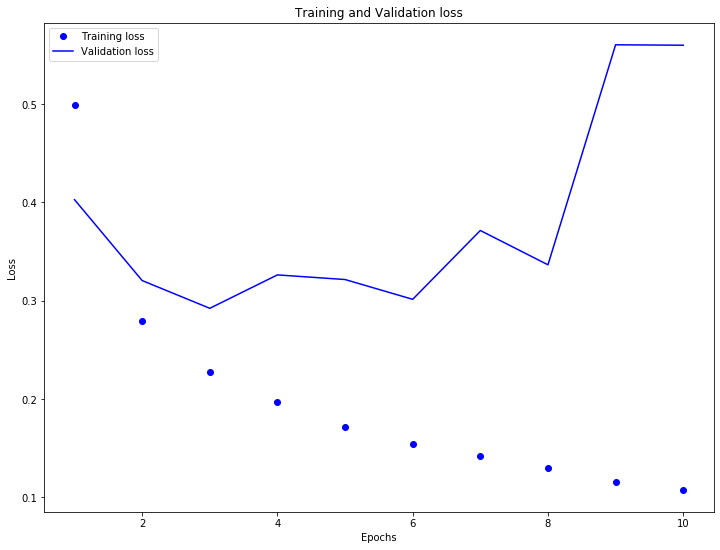

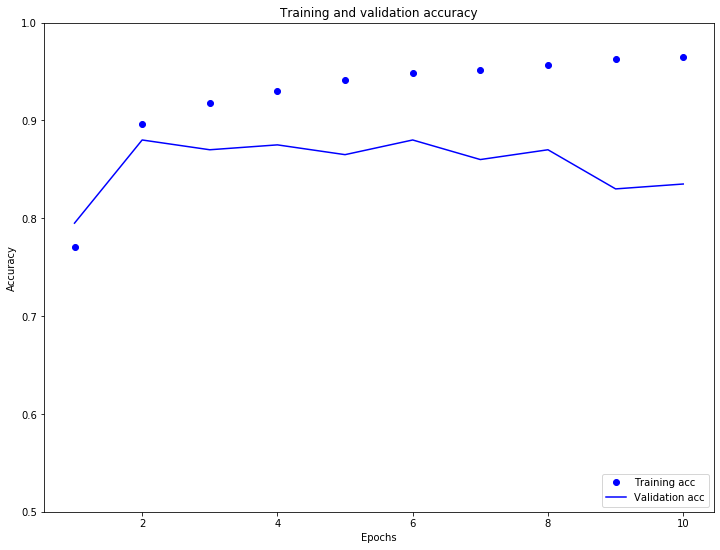

In [17]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim(0.5,1)
plt.show()

###检索学习的嵌入
接下来，让我们检索在训练中学习到的词嵌入。这将是形状矩阵`(vocab_size, embedding-dimension)`。

In [18]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) #shape:(vocab_size,embedding_dim)

(8185, 16)


现在，我们将权重写入磁盘。要使用Embedding Projector，我们将以制表符分隔的格式上传两个文件：一个向量文件（包含嵌入）和一个元数据文件（包含单词）。

In [0]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv','w',encoding='utf-8')
out_m = io.open('meta.tsv','w',encoding='utf-8')

for num,word in enumerate(encoder.subwords):
  vec = weights[num+1] #skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec])+"\n")

out_v.close()
out_m.close()

如果您正在Colaboratory中运行本教程，则可以使用以下代码片段将这些文件下载到本地计算机（或使用文件浏览器，查看->目录->文件浏览器）。

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

###可视化嵌入
为了可视化我们的嵌入，我们将它们上传到嵌入投影仪。

打开[Embedding Projector](http://projector.tensorflow.org/)（也可以在本地TensorBoard实例中运行）。

* 点击“加载数据”。

* 上载我们在上面创建的两个文件：`vecs.tsv`和`meta.tsv`。

现在将显示您已训练的嵌入。您可以搜索单词以找到其最近的邻居。例如，尝试搜索“美丽”。您可能会看到邻居喜欢“很棒”。

> 注意：您的结果可能会有所不同，具体取决于训练嵌入层之前如何随机初始化权重。

> 注意：通过实验，您可以通过使用更简单的模型来产生更多可解释的嵌入。尝试删除Dense(16)图层，重新训练模型，然后再次可视化嵌入。
嵌入式投影仪的屏幕截图
![](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1)
###下一步
本教程向您展示了如何在一个小的数据集上从头开始训练和可视化单词嵌入。

* 要了解递归网络，请参阅《Keras RNN指南》。

* 要了解有关文本分类的更多信息（包括整个工作流程，以及如果您对何时使用嵌入还是一次性编码感到好奇），我们建议您使用此实用的文本分类指南。
